<a href="https://colab.research.google.com/github/dhlinhdan/CS431.N11_450_Bird_Classification/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!pip install -U efficientnet

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"homyhanh","key":"e94623efbca739c2e616de7ccd1d5a84"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
! echo '{"username":"homyhanh","key":"e94623efbca739c2e616de7ccd1d5a84"}' > ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.69G/1.69G [00:50<00:00, 38.3MB/s]
100% 1.69G/1.69G [00:50<00:00, 36.0MB/s]


In [ ]:
!unzip 100-bird-species.zip

In [ ]:
# Import Module
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/valid'
test_dir = '/content/test'


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
class_name = sorted (os.listdir(train_dir))
CLASSES = len (class_name)


In [ ]:
dict_bird_name = {}
for i in range (CLASSES):
  dict_bird_name[i] = class_name[i]
dict_bird_name

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    fill_mode='constant',
    cval=0xCC,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=100)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [ ]:
def create_model():
  # Create Model
  model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
  model_ENB0.trainable = False
  # print ('1')
  # model_ENB0.summary()

  model = Sequential()
  model.add(model_ENB0)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.2))
  model.add(Dense(CLASSES,activation="softmax"))
  # print ('2')
  # model.summary()
  return model
  

In [ ]:
def train_fine_tuning (new_model, choice_batch_size, choice_learning_rate, choice_optimizers, choice_epochs, choice_momentum = 0, get_early_stopping = False):
  # Load Traning Data
  train_generator = train_datagen.flow_from_directory(
              train_dir,
              target_size=(IMG_WIDTH,IMG_HEIGHT),
              batch_size=choice_batch_size,
              class_mode='categorical',
              shuffle=True
          )
  # Load Validation Data
  validation_generator = validation_datagen.flow_from_directory(
              validation_dir,
              target_size=(IMG_WIDTH,IMG_HEIGHT),
              batch_size=choice_batch_size,
              class_mode='categorical',
              shuffle=True
          )
  # Pre Training
  if (choice_optimizers == 'adam'):
    new_model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.Adam(learning_rate=choice_learning_rate),
                metrics=['accuracy'])
  elif (choice_optimizers == 'sgd'):
    if (choice_momentum == 0):
      new_model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.SGD(learning_rate=choice_learning_rate),
                metrics=['accuracy'])
    else:
      new_model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.SGD(learning_rate=choice_learning_rate, momentum = choice_momentum),
                metrics=['accuracy'])
  else:
    new_model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.RMSprop(learning_rate=choice_learning_rate),
                metrics=['accuracy'])
  STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size

  if not get_early_stopping:
    history_ = new_model.fit(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=choice_epochs,
                              
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID)
  else:
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history_ = new_model.fit(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=choice_epochs,
                              
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID, callbacks = [callback])
  return new_model, history_

# Choose best hyperparameters

In [ ]:
new_model = create_model()

In [ ]:
model, history_ = train_fine_tuning (new_model, 64, 1e-3, 'adam', 5)

In [ ]:
df = pd.DataFrame({'accuracy': history_.history['accuracy'],
                   'loss': history_.history['loss'], 
                   'val_accuracy': history_.history['val_accuracy'],
                   'val_loss': history_.history['val_loss']}, 
                  index=['epoch ' + str(i) for i in range (1,6)])
df

,accuracy,loss,val_accuracy,val_loss
epoch 1,0.288339,4.585929,0.639286,3.384114
epoch 2,0.611015,2.748535,0.792857,2.117956
epoch 3,0.699011,1.962946,0.855357,1.478175
epoch 4,0.736465,1.569878,0.880357,1.114994
epoch 5,0.763280,1.329478,0.895089,0.890695


In [ ]:
export_csv = df.to_csv (r'/content/drive/MyDrive/DeepLearning/model_7_result.csv', index_label = 'epochs', header=True)

In [ ]:
path = '/content/drive/MyDrive/Models'
models = [[64, 1e-2, 'adam'], [64, 1e-3, 'adam'], [64, 1e-4, 'adam'], [32, 1e-2, 'adam'], [32, 1e-3, 'adam'], [32, 1e-4, 'adam'], [64, 1e-2, 'rmspop'], [64, 1e-3, 'rmspop'], [64, 1e-4, 'rmspop'],
[32, 1e-2, 'rmspop'], [32, 1e-3, 'rmspop'], [32, 1e-4, 'rmspop'], [64, 1e-2, 'sgd'], [64, 1e-2, 'sgd', 0.9], [64, 1e-2, 'sgd', 0.95], [64, 1e-3, 'sgd'], [64, 1e-3, 'sgd', 0.9], 
[64, 1e-3, 'sgd', 0.95], [64, 1e-4, 'sgd'], [64, 1e-4, 'sgd', 0.9], [64, 1e-4, 'sgd', 0.95], [32, 1e-2, 'sgd'], [32, 1e-2, 'sgd', 0.9], [32, 1e-2, 'sgd', 0.95], [32, 1e-3, 'sgd'], 
[32, 1e-3, 'sgd', 0.9], [32, 1e-3, 'sgd', 0.95], [32, 1e-4, 'sgd'], [32, 1e-4, 'sgd', 0.9], [32, 1e-4, 'sgd', 0.95]]


In [ ]:
result = pd.read_csv(os.path.join(path, 'model_1_result.csv'))
result['accuracy'].max()

0.7746662497520447

In [ ]:
for i in range (len (models)):
  result = pd.read_csv(os.path.join(path, 'model_'+str(i+1)+'_result.csv'))
  print (models[i])
  print (result['accuracy'].max())
  print ('--------------------------------------------------------------')



In [ ]:
max_val_acc = 0
index = 0
for i in (os.listdir(path)):
  df = pd.read_csv(path + '/' + i)
  if max_val_acc < df['val_accuracy'].max():
    max_val_acc = df['val_accuracy'].max() 
    index = int (''.join(re.findall(r'\d', i))) - 1
best_hyperparameter = models[index]

In [ ]:
best_hyperparameter

[64, 0.001, 'adam']

# Train

In [ ]:
# Unfreezing
model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))
model_ENB0.trainable = True
set_trainable = False

for layer in model_ENB0.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False

model = Sequential()
model.add(model_ENB0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(450,activation="softmax"))      


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 450)               576450    
                                                                 
Total params: 4,626,021
Trainable params: 1,919,218
Non-trainable params: 2,706,803
_________________________________________________________________


In [ ]:
index_model = 2

In [ ]:
model = load_model('/content/drive/MyDrive/DeepLearning/Best_Model' + '/best_model_' + str (index_model-1) + '.h5')

In [ ]:
# Fine Tuning
best_model, best_history = train_fine_tuning (model, 64, 1e-3, 'adam', 10, 0, get_early_stopping=True)

Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.
Epoch 1/10
1103/1103 [==============================] - 766s 681ms/step - loss: 0.2683 - accuracy: 0.9217 - val_loss: 0.1577 - val_accuracy: 0.9567
Epoch 2/10
1103/1103 [==============================] - 748s 678ms/step - loss: 0.2449 - accuracy: 0.9288 - val_loss: 0.1369 - val_accuracy: 0.9603
Epoch 3/10
1103/1103 [==============================] - 748s 678ms/step - loss: 0.2388 - accuracy: 0.9306 - val_loss: 0.1525 - val_accuracy: 0.9567
Epoch 4/10
1103/1103 [==============================] - 747s 677ms/step - loss: 0.2329 - accuracy: 0.9322 - val_loss: 0.1491 - val_accuracy: 0.9603
Epoch 5/10
1103/1103 [==============================] - 749s 679ms/step - loss: 0.2222 - accuracy: 0.9343 - val_loss: 0.1671 - val_accuracy: 0.9567


In [ ]:
best_model.save('/content/drive/MyDrive/DeepLearning/Best_Model' + '/best_model_' + str (index_model) + '.h5') 

In [ ]:
best_history.history['accuracy']

[0.9217000603675842,
 0.9287576675415039,
 0.9305716753005981,
 0.9321731328964233,
 0.9343414306640625]

In [ ]:
df = pd.DataFrame({'accuracy': best_history.history['accuracy'],
                   'loss': best_history.history['loss'], 
                   'val_accuracy': best_history.history['val_accuracy'],
                   'val_loss': best_history.history['val_loss']}, 
                  index=['epoch ' + str(index_model * 10 + i) for i in range (1,len (best_history.history['accuracy']) + 1)])
df

,accuracy,loss,val_accuracy,val_loss
epoch 11,0.921700,0.268267,0.956696,0.157746
epoch 12,0.928758,0.244899,0.960268,0.136925
epoch 13,0.930572,0.238838,0.956696,0.152549
epoch 14,0.932173,0.232944,0.960268,0.149064
epoch 15,0.934341,0.222220,0.956696,0.167053


In [ ]:
export_csv = df.to_csv (r'/content/drive/MyDrive/DeepLearning/Best_Model' + '/best_model_' + str (index_model) + '_result.csv', index_label = 'epochs', header=True)

In [ ]:
df0 = pd.read_csv('/content/drive/MyDrive/DeepLearning/Best_Model/best_model_0_result.csv')
df1 = pd.read_csv('/content/drive/MyDrive/DeepLearning/Best_Model/best_model_1_result.csv')

In [ ]:
df = pd.concat([df0, df1], ignore_index = True)
df.to_csv (r'/content/drive/MyDrive/DeepLearning/Best_Model/best_model_result.csv', header=True)

In [ ]:
df

,epochs,accuracy,loss,val_accuracy,val_loss
0,epoch 1,0.676384,1.375950,0.922768,0.281616
1,epoch 2,0.837490,0.612714,0.935714,0.220367
2,epoch 3,0.866217,0.490437,0.942857,0.196605
3,epoch 4,0.883620,0.419977,0.951339,0.163495
4,epoch 5,0.895043,0.378906,0.955357,0.166858
5,epoch 6,0.903333,0.345817,0.958036,0.153504
6,epoch 7,0.906678,0.323245,0.950446,0.174767
7,epoch 8,0.914430,0.298324,0.955804,0.153359
8,epoch 9,0.917604,0.284960,0.950446,0.166642
9,epoch 10,0.921728,0.268781,0.953125,0.153581


In [ ]:
df.iloc[:,1:]

,accuracy,loss,val_accuracy,val_loss
0,0.676384,1.375950,0.922768,0.281616
1,0.837490,0.612714,0.935714,0.220367
2,0.866217,0.490437,0.942857,0.196605
3,0.883620,0.419977,0.951339,0.163495
4,0.895043,0.378906,0.955357,0.166858
5,0.903333,0.345817,0.958036,0.153504
6,0.906678,0.323245,0.950446,0.174767
7,0.914430,0.298324,0.955804,0.153359
8,0.917604,0.284960,0.950446,0.166642
9,0.921728,0.268781,0.953125,0.153581


In [ ]:
result = pd.read_csv('/content/drive/MyDrive/DeepLearning/Best_Model/best_model_result.csv').iloc[:,1:]
result

,epochs,accuracy,loss,val_accuracy,val_loss
0,epoch 1,0.676384,1.375950,0.922768,0.281616
1,epoch 2,0.837490,0.612714,0.935714,0.220367
2,epoch 3,0.866217,0.490437,0.942857,0.196605
3,epoch 4,0.883620,0.419977,0.951339,0.163495
4,epoch 5,0.895043,0.378906,0.955357,0.166858
5,epoch 6,0.903333,0.345817,0.958036,0.153504
6,epoch 7,0.906678,0.323245,0.950446,0.174767
7,epoch 8,0.914430,0.298324,0.955804,0.153359
8,epoch 9,0.917604,0.284960,0.950446,0.166642
9,epoch 10,0.921728,0.268781,0.953125,0.153581


#Evaluation

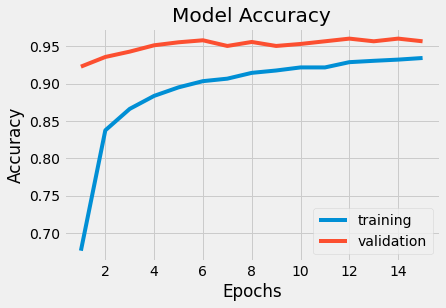

In [ ]:
epochs = len(df)
plt.style.use('fivethirtyeight')
plt.title('Model Accuracy')
plt.plot(range(1, epochs+1), df['accuracy'], label="training")
plt.plot(range(1, epochs+1), df['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

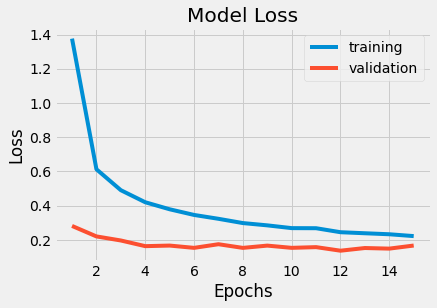

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Model Loss')
plt.plot(range(1, epochs+1), df['loss'], label="training")
plt.plot(range(1, epochs+1), df['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/DeepLearning/Best_Model/best_model_1.h5')

In [ ]:
# Load Test Data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=1,
            class_mode='categorical',
            shuffle=False
          )

Found 2250 images belonging to 450 classes.


In [ ]:
new_model_evaluation = model.evaluate(test_generator, verbose=1)

2250/2250 [==============================] - 39s 14ms/step - loss: 0.1099 - accuracy: 0.9689


In [ ]:
predict = model.predict (test_generator)

2250/2250 [==============================] - 203s 89ms/step


In [ ]:
# Path test image
img_test = []
for i in sorted (os.listdir(test_dir)):
  bird = os.path.join(test_dir, i)
  for j in sorted(os.listdir(bird)):
    img_test.append (os.path.join(bird, j))

In [ ]:
#Predict images
true_labels = []
pred_labels = []
for k in range (len (test_generator)):
  images = img_test [k]
  true_label = np.argmax (test_generator[k][1])
  pred_label = np.argmax (model.predict (test_generator[k][0]))
  true_labels.append (true_label)
  pred_labels.append (pred_label)


In [ ]:
print ('Accuracy', accuracy_score(true_labels, pred_labels))
print ('Precision:', precision_score(true_labels, pred_labels, average='macro'))
print ('Recall:', recall_score(true_labels, pred_labels, average='macro'))
print ('F1-score:', f1_score(true_labels, pred_labels, average='macro'))

Accuracy 0.9688888888888889
Precision: 0.9743306878306879
Recall: 0.9688888888888889
F1-score: 0.9682503792503793


In [ ]:
def accuracy (y_true, y_pred):
  sum = 0
  n = len(y_true)
  for i in range (n):
    sum+=int (y_true[i]==y_pred[i])
  return sum/n

def precision(matrix, n):
    avg_precise = 0
    for i in range(n):
        tp = matrix[i][i]
        pred = np.sum(matrix[:, i])
        if pred !=0:
          avg_precise += tp / pred

    return avg_precise / n


def recall(matrix, n):
    avg_recall = 0
    for i in range(n):
        tp = matrix[i][i]
        true = np.sum(matrix[i, :])
        avg_recall += tp / true

    return avg_recall / n


def f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [ ]:
X = confusion_matrix(true_labels, pred_labels)

In [ ]:
print ('Accuracy:', accuracy (true_labels, pred_labels))
print ('Precision:', precision(X, CLASSES))
print ('Recall:', recall(X, CLASSES))
print ('F1-score:', f1_score (precision(X, CLASSES), recall(X, CLASSES)))

Accuracy: 0.9688888888888889
Precision: 0.9743306878306879
Recall: 0.9688888888888898
F1-score: 0.9716021687433344


# Predict

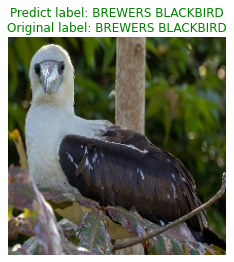

In [ ]:
path_img_test = '/content/test/ABBOTTS BOOBY/2.jpg'
plt.imshow(cv2.imread(path_img_test)[:,:,::-1])
if (dict_bird_name[pred_labels[k]] == A[3]):
  plt.title(f'Predict label: {dict_bird_name[pred_labels[k]]}\nOriginal label: {A[3]}', color="green")
else:
  plt.title(f'Predict label: {dict_bird_name[pred_labels[k]]}\nOriginal label: {A[3]}', color="red")
plt.axis('off')
plt.savefig('bird.png')

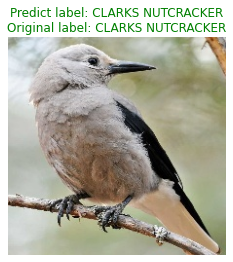

In [ ]:
# Choose random test_image 
k = random.randint (1, len(test_generator))
plt.imshow(cv2.imread(img_test[k])[:,:,::-1])
if (dict_bird_name[pred_labels[k]] == dict_bird_name[true_labels[k]]):
  plt.title(f'Predict label: {dict_bird_name[pred_labels[k]]}\nOriginal label: {dict_bird_name[true_labels[k]]}', color="green")
else:
  plt.title(f'Predict label: {dict_bird_name[pred_labels[k]]}\nOriginal label: {dict_bird_name[true_labels[k]]}', color="red")
plt.axis('off')
plt.savefig('bird.png')


In [ ]:
# Green: perfect score / Red: imperfect score
for i in range(CLASSES):
    score_sum = 0
    for j in range(5):
        score_sum += int(true_labels[i*5+j] == pred_labels[i*5+j])
    if score_sum == 5:
        print('\033[92m' + '{}: {} / 5'.format(dict_bird_name[i], score_sum))
    else:
        print('\033[91m' + '{}: {} / 5'.format(dict_bird_name[i], score_sum))


ABBOTTS BABBLER: 5 / 5
ABBOTTS BOOBY: 5 / 5
ABYSSINIAN GROUND HORNBILL: 5 / 5
AFRICAN CROWNED CRANE: 5 / 5
AFRICAN EMERALD CUCKOO: 5 / 5
AFRICAN FIREFINCH: 5 / 5
AFRICAN OYSTER CATCHER: 5 / 5
AFRICAN PIED HORNBILL: 5 / 5
ALBATROSS: 5 / 5
ALBERTS TOWHEE: 5 / 5
ALEXANDRINE PARAKEET: 5 / 5
ALPINE CHOUGH: 5 / 5
ALTAMIRA YELLOWTHROAT: 4 / 5
AMERICAN AVOCET: 5 / 5
AMERICAN BITTERN: 5 / 5
AMERICAN COOT: 5 / 5
AMERICAN FLAMINGO: 5 / 5
AMERICAN GOLDFINCH: 5 / 5
AMERICAN KESTREL: 5 / 5
AMERICAN PIPIT: 5 / 5
AMERICAN REDSTART: 4 / 5
AMERICAN WIGEON: 5 / 5
AMETHYST WOODSTAR: 5 / 5
ANDEAN GOOSE: 4 / 5
ANDEAN LAPWING: 5 / 5
ANDEAN SISKIN: 5 / 5
ANHINGA: 5 / 5
ANIANIAU: 4 / 5
ANNAS HUMMINGBIRD: 5 / 5
ANTBIRD: 5 / 5
ANTILLEAN EUPHONIA: 4 / 5
APAPANE: 5 / 5
APOSTLEBIRD: 5 / 5
ARARIPE MANAKIN: 5 / 5
ASHY STORM PETREL: 3 / 5
ASHY THRUSHBIRD: 4 / 5
ASIAN CRESTED IBIS: 5 / 5
ASIAN DOLLARD BIRD: 5 / 5
AUCKLAND SHAQ: 5 / 5
AUSTRAL CANASTERO: 3 / 5
AUSTRALASIAN FIGBIRD: 5 / 5
AVADAVAT: 3 / 5
AZARAS SPINETAIL: